## Data Fetching

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
import pandas as pd
from keras import layers, Model
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D, PReLU, LeakyReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, Dense, Input , Add
from keras.applications import VGG19
from keras.models import load_model
from tqdm import tqdm

In [2]:
img_path  = 'mirflickr400'
print(os.listdir(img_path))

['large_img', 'small_img']


In [3]:
large_img_dir = os.listdir('mirflickr400/large_img')
large_data_25 = large_img_dir[:25]
large_data_25

['large1001.jpg',
 'large1002.jpg',
 'large1003.jpg',
 'large1004.jpg',
 'large1005.jpg',
 'large1006.jpg',
 'large1007.jpg',
 'large1008.jpg',
 'large1009.jpg',
 'large1010.jpg',
 'large1011.jpg',
 'large1012.jpg',
 'large1013.jpg',
 'large1014.jpg',
 'large1015.jpg',
 'large1016.jpg',
 'large1017.jpg',
 'large1018.jpg',
 'large1019.jpg',
 'large1020.jpg',
 'large1021.jpg',
 'large1022.jpg',
 'large1023.jpg',
 'large1024.jpg',
 'large1025.jpg']

In [4]:
def show_img(path):
    img = Image.open(path)
    plt.imshow(img)

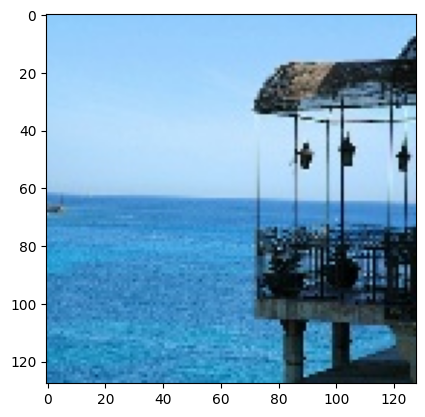

In [5]:
from random import randint
val = randint(1, 20)
img_path = 'mirflickr400/large_img/' + large_data_25[val]
show_img(img_path)

In [6]:
#making residual blocks
def res_blocks(input):
    x = Conv2D(64, (3,3),  padding='same')(input)
    x = keras.layers.BatchNormalization(momentum=0.5)(x)
    x = keras.layers.PReLU(shared_axes=[1,2])(x)
    
    x = keras.layers.Conv2D(64, (3,3) , padding= 'same')(x)
    x = keras.layers.BatchNormalization(momentum=0.5)(x)
    return keras.layers.add([input, x])

def upscale_block(ip):
    up_model = Conv2D(256, (3,3), 1, padding='same')(ip)
    up_model = keras.layers.UpSampling2D(size= 2)(up_model)
    up_model = keras.layers.PReLU(shared_axes=[1,2])(up_model)
    return up_model

## Generator

In [7]:
#Make Generator
def Generator(input, num_res_blocks):
    layer = keras.layers.Conv2D(64, (9,9),  padding= 'same')(input)
    layer = keras.layers.PReLU(shared_axes=[1,2])(layer)
    # keep this layer into temp variable
    temp = layer
    # add residual blocks
    for i in range(num_res_blocks):
        layer = res_blocks(layer)
    layer = keras.layers.Conv2D(64, (3, 3), 1, padding= 'same')(layer)
    layer = keras.layers.BatchNormalization(momentum=0.5)(layer)
    layer = keras.layers.add([layer, temp])
    
    #add two upscale blocks
    layer = upscale_block(layer)
    layer = upscale_block(layer)
    output = keras.layers.Conv2D(3, (9,9), 1, padding='same')(layer)
    return Model(input, output)

## Descriminator

In [8]:
# make descriminator
def descriminator_block(input, n, strides, bn= True):
    layer = Conv2D(n, (3,3), strides=strides, padding= 'same')(input)
    if bn:
        layer = keras.layers.BatchNormalization(momentum=0.5)(layer)
    layer = keras.layers.LeakyReLU(0.5)(layer)
    return layer

In [9]:
def Descriminator(input):
    n = 64
    d1 = descriminator_block(input, n, 1, bn=False)
    d2 = descriminator_block(d1, n, 2)
    d3 = descriminator_block(d2, n*2, 1)
    d4 = descriminator_block(d3, n*2, 2)
    d5 = descriminator_block(d4, n*4, 1)
    d6 = descriminator_block(d5, n*4, 2)
    d7 = descriminator_block(d6, n*8, 1)
    d8 = descriminator_block(d7, n*8, 2)
    d8_5 = keras.layers.Flatten()(d8)
    d9 = keras.layers.Dense(n*16)(d8_5)
    d10 = keras.layers.LeakyReLU(negative_slope=0.2)(d9)
    output = keras.layers.Dense(1, activation='sigmoid')(d10) # why sigmoid ->  descriminator is a binary classifier 
    
    return Model(input, output)

## combined Model

In [10]:
# Build vgg for feature extraction
def build_vgg(hr_shape):
    vgg = keras.applications.VGG19(include_top= False, weights= 'imagenet', input_shape= hr_shape)
    return Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

In [11]:
def create_Comb(Generator, Descriminator, vgg, lr_img, hr_img):
    gen_img = Generator(lr_img)
    #make image features using VGG
    gen_features = vgg(gen_img)
    Descriminator.trainable = False
    validity = Descriminator(gen_img)
    return keras.Model(inputs= [lr_img, hr_img], outputs = [validity, gen_features] )

In [12]:
n = 5000
lr_list = os.listdir('mirflickr400/small_img')
lr_images = []
for img in lr_list:
    path = os.path.join('mirflickr400/small_img', img)
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    lr_images.append(img)
    

In [13]:
hr_list = os.listdir('mirflickr400/large_img')
hr_images = []
for img in hr_list:
    path = os.path.join('mirflickr400/large_img', img)
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    hr_images.append(img)

In [14]:
len(lr_images), len(hr_images)

(400, 400)

In [15]:
# lr_images = lr_images[:1000]
# hr_images = hr_images[:1000]

In [16]:
len(lr_images), len(hr_images)

(400, 400)

In [17]:
#Converting  list to np.array
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

In [18]:
lr_images[0]

array([[[149, 103,  69],
        [148, 104,  65],
        [145, 107,  62],
        ...,
        [186, 158, 119],
        [195, 154,  98],
        [197, 152,  85]],

       [[146, 103,  68],
        [149, 110,  71],
        [151, 114,  69],
        ...,
        [180, 156, 122],
        [195, 158, 103],
        [195, 152,  84]],

       [[147, 111,  75],
        [152, 119,  78],
        [152, 121,  74],
        ...,
        [190, 172, 148],
        [188, 155, 102],
        [201, 161,  92]],

       ...,

       [[139,  97,  47],
        [144, 103,  51],
        [152, 111,  55],
        ...,
        [145,  88,  58],
        [218, 170, 121],
        [212, 170, 110]],

       [[144, 102,  54],
        [150, 110,  59],
        [146, 106,  54],
        ...,
        [102,  49,  18],
        [206, 158, 109],
        [214, 170, 109]],

       [[139,  97,  49],
        [149, 109,  58],
        [141, 104,  52],
        ...,
        [ 82,  33,   3],
        [182, 134,  85],
        [216, 170, 110]]

In [19]:
def show_lr_and_hr_img(index):
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.title('Low Res Image')
    plt.imshow(np.reshape(lr_images[index], (32, 32, 3)))  
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(np.reshape(hr_images[index], (128, 128, 3)))
    plt.title('High Res Image')
    plt.axis('off')

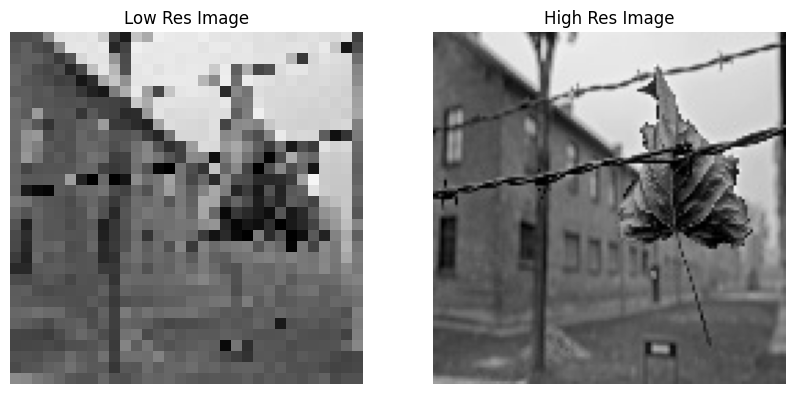

In [20]:
index = randint(0, len(lr_images)-1)
show_lr_and_hr_img(index)

## Data Preprocessing

### Scaling Images

In [21]:
lr_images = (lr_images/255).astype(np.float32)
hr_images = (hr_images/255).astype(np.float32)

In [22]:
hr_images[0]

array([[[0.53333336, 0.3882353 , 0.21176471],
        [0.54901963, 0.40392157, 0.22745098],
        [0.5411765 , 0.39607844, 0.21960784],
        ...,
        [0.76862746, 0.6039216 , 0.3137255 ],
        [0.77254903, 0.5882353 , 0.3137255 ],
        [0.8       , 0.6156863 , 0.34117648]],

       [[0.53333336, 0.3882353 , 0.21568628],
        [0.5568628 , 0.4117647 , 0.23529412],
        [0.54901963, 0.40392157, 0.23137255],
        ...,
        [0.77254903, 0.6       , 0.32156864],
        [0.7647059 , 0.5882353 , 0.32156864],
        [0.78431374, 0.6       , 0.33333334]],

       [[0.5411765 , 0.39607844, 0.23137255],
        [0.5647059 , 0.41960785, 0.24705882],
        [0.54901963, 0.40392157, 0.23921569],
        ...,
        [0.78431374, 0.60784316, 0.34509805],
        [0.7764706 , 0.59607846, 0.3529412 ],
        [0.78039217, 0.6       , 0.35686275]],

       ...,

       [[0.49411765, 0.3372549 , 0.19607843],
        [0.54509807, 0.39215687, 0.23921569],
        [0.50980395, 0

#### Data Splitting

In [23]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.3,  random_state= 100)

In [24]:
lr_train.shape, lr_test.shape, hr_train.shape, hr_test.shape

((280, 32, 32, 3), (120, 32, 32, 3), (280, 128, 128, 3), (120, 128, 128, 3))

In [25]:
#get lr and hr shape
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape, hr_shape 

((32, 32, 3), (128, 128, 3))

In [26]:
lr_ip = Input(shape= lr_shape)
hr_ip = Input(shape= hr_shape)
lr_ip, hr_ip

(<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=keras_tensor>,
 <KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=None, name=keras_tensor_1>)

## Model Building

In [27]:
generator = Generator(input= lr_ip, num_res_blocks= 16)

In [28]:
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ p_re_lu[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 2,044,291 (7.80 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 4,224 (16.50 KB)

In [29]:
discriminator = Descriminator(hr_ip)
discriminator.compile('adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [30]:
discriminator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,80

 Total params: 38,249,281 (145.91 MB)

 Trainable params: 38,245,569 (145.90 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [31]:
vgg= build_vgg(hr_shape)
print(vgg.summary())
vgg.trainable = False

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,568 (8.87 MB)

 Trainable params: 2,325,568 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
GAN_MODEL = create_Comb(generator, discriminator, vgg, lr_ip, hr_ip) 
GAN_MODEL.compile(optimizer= 'adam', loss= ['binary_crossentropy', 'mse'], loss_weights= [1e-3, 1])

In [33]:
GAN_MODEL.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128, 128,  │  2,044,291 │ input_layer[0][0] │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 1)         │ 38,249,281 │ functional_1[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 32, 32,    │  2,325,568 │ functional_1[0][… │
│ (Functional)        │ 256)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,619,140 (162.58 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 40,579,073 (154.80 MB)

## Model Training

### Define Batch 

In [34]:
#create a list of images for hr and lr in batches 
batch_size = 1
train_lr_batch = []
train_hr_batch = []
for it in range(int(hr_train.shape[0]/ batch_size)):
    start_idx = it* batch_size
    end_idx = start_idx + batch_size
    train_hr_batch.append(hr_train[start_idx: end_idx])
    train_lr_batch.append(lr_train[start_idx: end_idx])

In [35]:
EPOCH = 5
for e in range(EPOCH):
    fake_label = np.zeros((batch_size, 1)) #assign a label of zero to all fake images
    real_label = np.ones((batch_size, 1))  #assign a label of ones to all fake images
    # Create empty Lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches
    for b in tqdm(range(len(train_hr_batch))):
        lr_imgs =  train_lr_batch[b]
        hr_imgs =  train_hr_batch[b]
        
        fake_imgs = generator.predict_on_batch(lr_imgs)
        
        ##First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        # Now, train the generator by fixing discriminator as non-trainoble
        discriminator.trainable = False 
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_gen)
        
        # Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
        
        #train the Generator via GAN 
        # Remember that we have 2 Losses,adversarial Loss and content (VGG) Loss
        
        g_loss, _, _ = GAN_MODEL.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #save loss to a list so we can average
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    # Convert the List of Losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis = 0) / len(g_losses)
    d_loss = np.sum(d_losses, axis = 0) / len(d_losses)

    #report the progress during training
    print('epoch:', e+1, 'g_loss:', g_loss, 'd_loss:', d_loss)
    if (e+1) % 1 == 0:
        # Save the generator after every n epochs (Usually 5 epocns)
        generator.save("model"+ str(e+1) +".h5")
        


  0%|          | 0/280 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


  0%|          | 1/280 [00:44<3:25:33, 44.21s/it]


KeyboardInterrupt: 

## Model Testing

In [ ]:
model1 = load_model('model\model1.h5', compile = False)
# model2 = load_model('model\model2.h5', compile = False)
# model3 = load_model('model\model3.h5', compile = False)

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\raunak\AppData\Local\Temp\ipykernel_6328\154571612.py:1: SyntaxWarning: invalid escape sequence '\m'
  model1 = load_model('model\model1.h5', compile = False)
C:\Users\raunak\AppData\Local\Temp\ipykernel_6328\154571612.py:2: SyntaxWarning: invalid escape sequence '\m'
  model2 = load_model('model\model2.h5', compile = False)
C:\Users\raunak\AppData\Local\Temp\ipykernel_6328\154571612.py:3: SyntaxWarning: invalid escape sequence '\m'
  model3 = load_model('model\model3.h5', compile = False)
C:\Users\raunak\AppData\Local\Temp\ipykernel_6328\154571612.py:1: SyntaxWarning: invalid escape sequence '\m'
  model1 = load_model('model\model1.h5', compile = False)
C:\Users\raunak\AppData\Loca

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model\model1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
[x1, x2]= [lr_test, hr_test]
x1, x2

(array([[[[0.9843137 , 1.        , 1.        ],
          [0.9843137 , 1.        , 1.        ],
          [0.972549  , 0.98039216, 1.        ],
          ...,
          [0.49411765, 0.53333336, 0.49803922],
          [0.5019608 , 0.50980395, 0.49019608],
          [0.50980395, 0.5137255 , 0.49411765]],
 
         [[0.9843137 , 1.        , 0.99607843],
          [0.96862745, 0.99607843, 1.        ],
          [0.96862745, 0.99215686, 1.        ],
          ...,
          [0.49411765, 0.52156866, 0.49019608],
          [0.49803922, 0.50980395, 0.48235294],
          [0.50980395, 0.5137255 , 0.48235294]],
 
         [[0.99607843, 1.        , 0.98039216],
          [0.972549  , 1.        , 1.        ],
          [0.8509804 , 0.91764706, 1.        ],
          ...,
          [0.5058824 , 0.5176471 , 0.49019608],
          [0.50980395, 0.50980395, 0.4627451 ],
          [0.5137255 , 0.5176471 , 0.4627451 ]],
 
         ...,
 
         [[0.33333334, 0.        , 0.35686275],
          [0.29803

In [ ]:
from numpy.random import randint
def predict(model):
    #select random index
    ind = np.array([10])
    src_img , tar_img = x1[ind], x2[ind]
    #generate image from source
    gen_img = model.predict(src_img)
    return src_img, gen_img, tar_img

In [ ]:
src1, gen1, tar1 = predict(model1)
# src2, gen2, tar2 = predict(model2)
# src3, gen3, tar3 = predict(model3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


In [ ]:
#plot all three images
def plot_img(src_img, gen_image, tar_img):
    plt.figure(figsize = (12, 10))
    plt.subplot(231)
    plt.title('LR Image')
    plt.imshow(src_img[0,:,:,:])
    plt.subplot(232)
    plt.title('Super Resolution')
    plt.imshow(gen_image[0,:,:,:])
    plt.subplot(233)
    plt.title('Original HR Image')
    plt.imshow(tar_img[0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


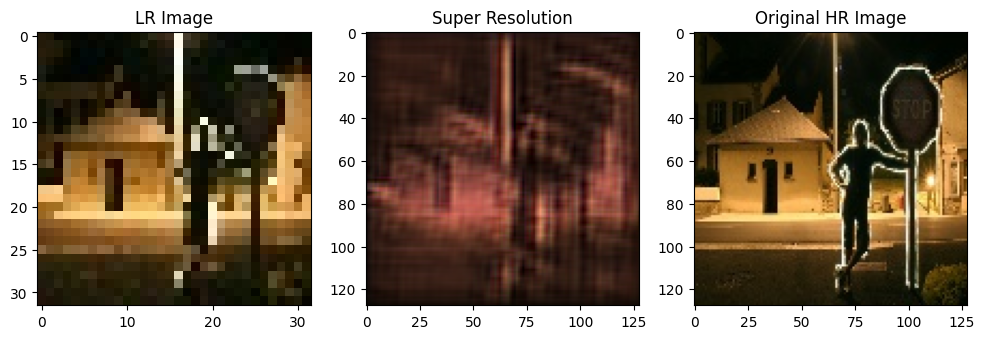

In [ ]:
plot_img(src1, gen1, tar1)